### Import and configuration

In [76]:
import os
import cv2
import random
import numpy as np
import tensorflow
from zipfile import ZipFile, is_zipfile
from kaggle import KaggleApi
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, 
    concatenate, Conv2DTranspose, BatchNormalization, 
    Dropout, Lambda, ReLU
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

set constants

In [51]:
PATH_TEST = '../data/external/test'
PATH_TRAIN = '../data/external/train'
PATH_MODEL = '../model'
PATH_LOG = '../model/logs'

IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNEL = 3
MASK_CHANNEL = 1

EPOCHS = 15
BATCH_SIZE = 8
RANDOM_SEED = 42
THRESHOULD = 0.5
LEARNING_RATE = 1e-4 #0.0001

In [4]:
np.random.seed = RANDOM_SEED
random.seed = RANDOM_SEED

In [5]:
def download_challenge_files(challenge_name: str, destination_path: str):
    api = KaggleApi()
    api.authenticate()
    
    api.competition_download_files(challenge_name, path=destination_path)
    
    for file in os.listdir(destination_path):
        file_path = os.path.join(destination_path, file)
        
        if is_zipfile(file_path):
            with ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(destination_path)
            os.remove(file_path)

In [3]:
challenge_name = 'data-science-bowl-2018'
destination_path = '../data/external'
download_challenge_files(challenge_name, destination_path)

In [ ]:
!unzip stage1_train.zip -d /data/external/treinamento/
!unzip stage1_test.zip -d /data/external/teste/

### Preprocessing images

In [6]:
train_ids = next(os.walk(PATH_TRAIN))[1]
test_ids = next(os.walk(PATH_TEST))[1]

In [7]:
len(train_ids), len(test_ids)

(670, 65)

In [8]:
dataset_img = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL), dtype=np.uint8)
dataset_mask = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, MASK_CHANNEL), dtype=np.bool_)

In [9]:
dataset_img.shape, dataset_mask.shape

((670, 256, 256, 3), (670, 256, 256, 1))

In [10]:
for i, filename in enumerate(train_ids):
    path = os.path.join(PATH_TRAIN, filename)

    img = cv2.imread(os.path.join(path, 'images', (filename + '.png')))[:,:,:IMG_CHANNEL]
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    dataset_img[i] = img

    mask_path = os.path.join(path, 'masks')
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, MASK_CHANNEL), dtype=np.bool_)
    for mask_file in next(os.walk(mask_path))[2]:
        mask_ = cv2.imread(os.path.join(mask_path, mask_file))
        mask_ = cv2.cvtColor(mask_, cv2.COLOR_BGR2GRAY)
        mask_ = np.expand_dims(cv2.resize(mask_, (IMG_HEIGHT, IMG_WIDTH)), axis = -1)
        mask = np.maximum(mask, mask_)
    
    dataset_mask[i] = mask

Text(0.5, 1.0, 'Máscara')

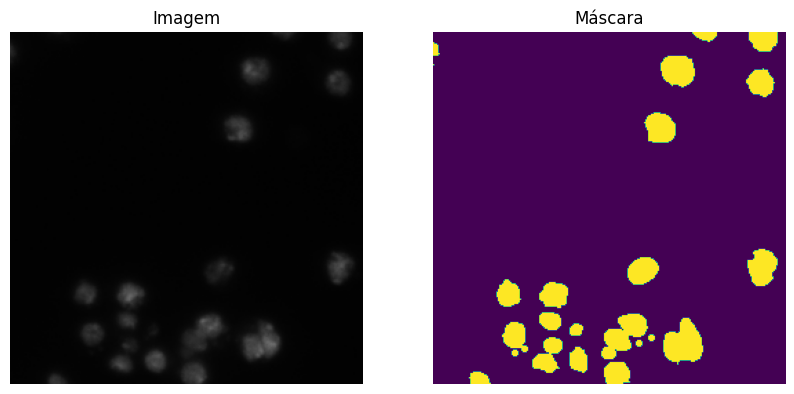

In [11]:
id_img = 0
fig = plt.figure(figsize=(10, 7))

fig.add_subplot(121)
plt.imshow(dataset_img[id_img])
plt.axis('off')
plt.title('Imagem')

fig.add_subplot(122)
plt.imshow(np.squeeze(dataset_mask[id_img]))
plt.axis('off')
plt.title('Máscara')

In [42]:
X_train, X_val, y_train, y_val = train_test_split(dataset_img, dataset_mask, test_size=0.10, random_state=RANDOM_SEED)

X_train.shape, X_val.shape

((603, 256, 256, 3), (67, 256, 256, 3))

### Model build

In [32]:
def block_conv(input, num_filters):
    x = Conv2D(num_filters, 3, padding='same')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [33]:
def block_encoder(input, num_filters):
    x = block_conv(input, num_filters)
    p = MaxPool2D((2,2))(x)
    return x, p

In [34]:
def block_decoder(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2,2), strides=2, padding='same')(input)
    x = Concatenate()([x, skip_features])
    x = block_conv(x, num_filters)
    return x

In [35]:
def build_model(input_shape):
    inputs = Input(input_shape)

    s1, p1 = block_encoder(inputs, 64)
    s2, p2 = block_encoder(p1, 128)
    s3, p3 = block_encoder(p2, 256)
    s4, p4 = block_encoder(p3, 512)

    b1 = block_conv(p4, 1024)

    d1 = block_decoder(b1, s4, 512)
    d2 = block_decoder(d1, s3, 256)
    d3 = block_decoder(d2, s2, 128)
    d4 = block_decoder(d3, s1, 64)

    outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(d4)

    model = Model(inputs, outputs, name='UNet')
    return model

In [36]:
model = build_model((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL))
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 256, 256, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 256, 256, 64  256        ['conv2d_6[0][0]']               
 rmalization)                   )                                                              

### Training

In [38]:
model_file = os.path.join(PATH_MODEL, 'model_unet.json')
model_json = model.to_json()

with open(model_file, 'w') as json_file:
    json_file.write(model_json)

In [40]:
model_name = os.path.join(PATH_MODEL, 'model_unet.h5')
checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
early_stopper = EarlyStopping(patience=5, monitor='val_loss')
callbacks = [checkpointer, early_stopper]

In [43]:
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val), callbacks=[callbacks])

Epoch 1/15
76/76 [==============================] - ETA: 0s - loss: 0.3273 - accuracy: 0.9043 
Epoch 00001: val_loss improved from inf to 0.40652, saving model to model_unet.h5
76/76 [==============================] - 912s 12s/step - loss: 0.3273 - accuracy: 0.9043 - val_loss: 0.4065 - val_accuracy: 0.9494
Epoch 2/15
76/76 [==============================] - ETA: 0s - loss: 0.1785 - accuracy: 0.9562 
Epoch 00002: val_loss improved from 0.40652 to 0.20138, saving model to model_unet.h5
76/76 [==============================] - 944s 12s/step - loss: 0.1785 - accuracy: 0.9562 - val_loss: 0.2014 - val_accuracy: 0.9649
Epoch 3/15
76/76 [==============================] - ETA: 0s - loss: 0.1298 - accuracy: 0.9664 
Epoch 00003: val_loss improved from 0.20138 to 0.13730, saving model to model_unet.h5
76/76 [==============================] - 1014s 13s/step - loss: 0.1298 - accuracy: 0.9664 - val_loss: 0.1373 - val_accuracy: 0.9683
Epoch 4/15
76/76 [==============================] - ETA: 0s - loss:

In [45]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [46]:
def show_val_metrics(history):
    fig = plt.gcf()
    fig.set_size_inches(16,4)
    plt.subplot(121)
    plt.plot(history.history['accuracy'], 'red', label='Accuracy treinamento')
    plt.plot(history.history['val_accuracy'], 'blue', label='Accuracy validação')
    plt.title('Acurácia')

    plt.subplot(122)
    plt.plot(history.history['loss'], 'red', label='Loss treinamento')
    plt.plot(history.history['val_loss'], 'blue', label='Loss validação')    
    plt.legend()
    plt.title('Loss')

    plt.show()

### Validation

In [47]:
len(X_val)

67

In [48]:
predict_val = model.predict(X_val) 
predict_val.shape #Sigmoide 0 e 1.

(67, 256, 256, 1)

In [49]:
predict_val[0].min(), predict_val[0].max()

(0.0024119914, 0.99999774)

In [52]:
predict_val = (predict_val > THRESHOULD).astype(np.uint8)
predict_val

array([[[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],
         [1],
         [1]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [1],
         [1]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [1],
         [0]]],


       [[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],


In [53]:
np.unique(predict_val[0], return_counts=True)

(array([0, 1], dtype=uint8), array([64422,  1114], dtype=int64))

In [66]:
def compare_segmentation(original, ground_truth, predict):
    fig = plt.figure(figsize=(12, 7))

    fig.add_subplot(1, 3, 1)
    plt.imshow(original)
    plt.axis('off')
    plt.title('Original image')

    gt = isinstance(ground_truth, np.ndarray)
    if gt:
        fig.add_subplot(1, 3, 2)
        plt.imshow(ground_truth)
        plt.axis('off')
        plt.title('Ground truth mask')

    fig.add_subplot(1, 3, 2 if not gt else 3)
    plt.imshow(predict)
    plt.axis('off')
    plt.title('Predict')

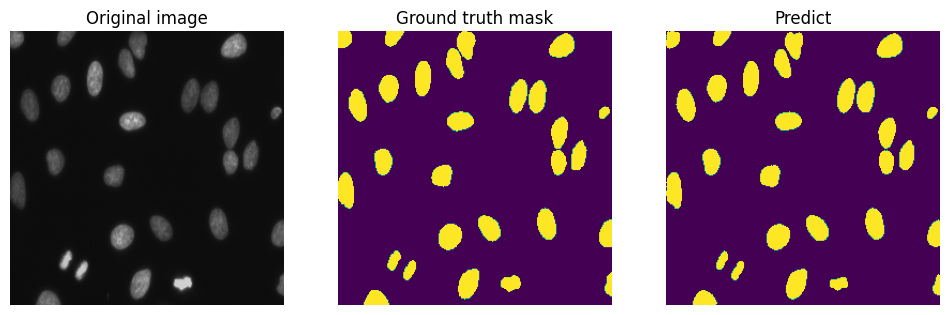

In [60]:
idx = np.random.randint(1, X_val.shape[0])
compare_segmentation(X_val[idx], np.squeeze(y_val[idx]), np.squeeze(predict_val[idx]))

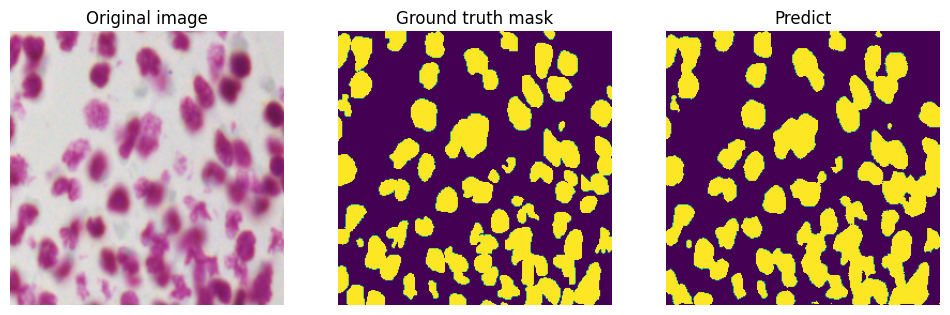

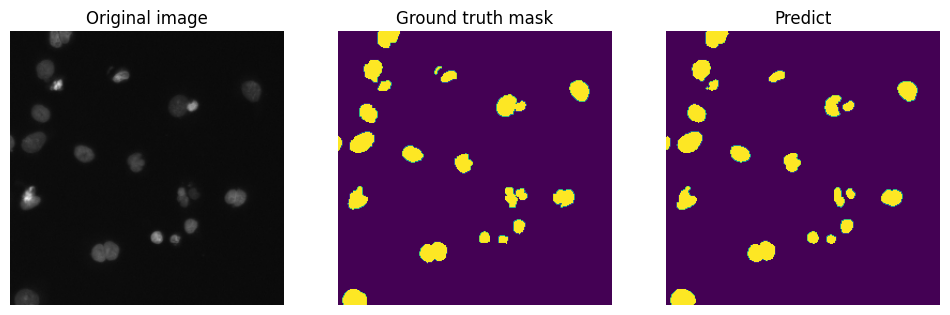

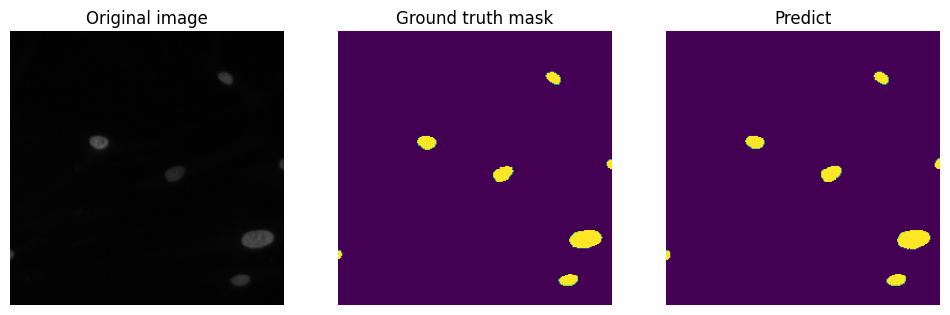

In [61]:
imgs_idx = np.random.choice(len(X_val), 3)

for idx in imgs_idx:
    compare_segmentation(X_val[idx], np.squeeze(y_val[idx]), np.squeeze(predict_val[idx]))

### Testing

In [62]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL), dtype=np.uint8)

for i, filename in enumerate(test_ids):
    path = os.path.join(PATH_TEST, filename)

    img = cv2.imread(os.path.join(path, 'images', (filename + '.png')))[:,:,:IMG_CHANNEL]
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    X_test[i] = img

In [63]:
predict_test = model.predict(X_test)
predict_test = (predict_test > THRESHOULD).astype(np.uint8)

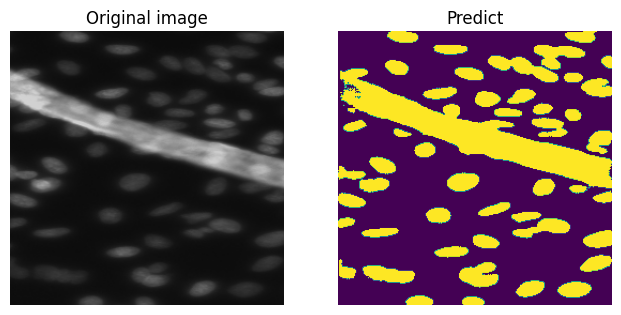

In [67]:
idx = np.random.randint(0, len(X_test))
compare_segmentation(X_test[idx], None, predict_test[idx])

### Evaluation

Text(0.5, 1.0, 'Ground truth mask')

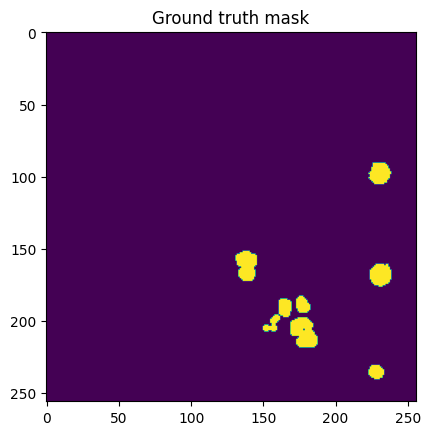

In [69]:
id_img_test = 0
img_test = X_val[id_img_test]
ground_truth = y_val[id_img_test]
plt.imshow(np.squeeze(ground_truth))
plt.title('Ground truth mask')

In [79]:
iou_result = MeanIoU(num_classes=2) #Background + mask segmentation

In [70]:
test_img_input = np.expand_dims(img_test, 0)
test_img_input.shape

(1, 256, 256, 3)

In [72]:
predict = (model.predict(test_img_input)[0,:,:,0] > THRESHOULD).astype(np.uint8)
predict

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 1, 0]], dtype=uint8)

Iou para imagem: 0.8977792


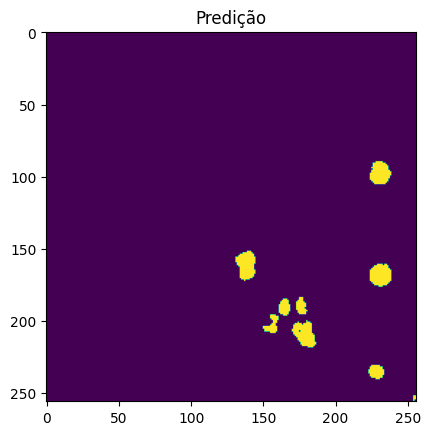

In [81]:
plt.imshow(predict)
plt.title('Predição')

iou_result.update_state(ground_truth[:,:,0], predict)
print('Iou para imagem:', iou_result.result().numpy())